NOTE: if the notebook hangs try cycling the jupyter extension through disable/enable 

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/projects/opendss_pv_system_issue`


In [2]:
import OpenDSSDirect as OpenDSS
using Plots

In [3]:
function load_dss(dssfilepath)
    work_dir = pwd()
    OpenDSS.dss("""
        clear
        compile $dssfilepath
    """)
    cd(work_dir)
end

load_dss (generic function with 1 method)

In [4]:
"""
    dss_voltages_pu()

return a dict with bus-name keys and per-unit voltages for each phase at each bus.
"""
function dss_voltages_pu()::Dict
    d = Dict()
    for b in OpenDSS.Circuit.AllBusNames() 
        OpenDSS.Circuit.SetActiveBus(b)
        d[b] = OpenDSS.Bus.puVmagAngle()[1:2:end]
    end
    return d
end

dss_voltages_pu

In [5]:
fpath = joinpath("IEEE13Nodeckt.dss")
load_dss(fpath)

In [6]:
dss_voltages_pu()

Dict{Any, Any} with 16 entries:
  "671"       => [1.00719, 1.04688, 0.940036]
  "680"       => [1.00719, 1.04688, 0.940036]
  "634"       => [1.00025, 1.01273, 0.971634]
  "652"       => [0.999555]
  "675"       => [1.00083, 1.04926, 0.937975]
  "650"       => [0.999813, 0.99989, 0.999805]
  "rg60"      => [1.04969, 1.03732, 1.06838]
  "611"       => [0.935682]
  "645"       => [1.02673, 0.98703]
  "632"       => [1.02708, 1.03316, 0.99362]
  "633"       => [1.02408, 1.03125, 0.990941]
  "684"       => [1.00523, 0.93785]
  "sourcebus" => [0.999886, 0.999895, 0.999832]
  "692"       => [1.00719, 1.04688, 0.940036]
  "670"       => [1.0206, 1.03693, 0.974364]
  "646"       => [1.02665, 0.98218]

In [7]:
kVA = 10000

function rebuild()
    load_dss(fpath)
    OpenDSS.dss("""
        new pvsystem.pv680 bus1=680 kV=4.16 kVa=$kVA pf=1 irrad=1.0  Pmpp=$kVA vminpu=0.6 vmaxpu=3.0
    """)
    
    OpenDSS.dss("""
    Batchedit Load..* vminpu=0.6 vmaxpu=3.0  ! ensure that load model stays constant power
    """)
    
    OpenDSS.dss("""
    Set MinIteration=500
    Set MaxIter=5000  ! default is 15, not enough to get load matching
    """)
    OpenDSS.Solution.Solve()
end

rebuild (generic function with 1 method)

# inject varying power and grab voltage to plot

## PF = 1

In [8]:
bus_to_plot = "670"
phase_to_plot = 1


rebuild()

OpenDSS.PVsystems.First()

vs_down = []
min_kVA = 6000



for pmpp in range(start=kVA, step=-100, stop=min_kVA)
    OpenDSS.PVsystems.Pmpp(float(pmpp))
    OpenDSS.Solution.Solve()
    push!(vs_down, dss_voltages_pu()[bus_to_plot][phase_to_plot])
end


vs_up = []

for pmpp in range(start=min_kVA, step=100, stop=kVA)
    OpenDSS.PVsystems.Pmpp(float(pmpp))
    OpenDSS.Solution.Solve()
    push!(vs_up, dss_voltages_pu()[bus_to_plot][phase_to_plot])
end


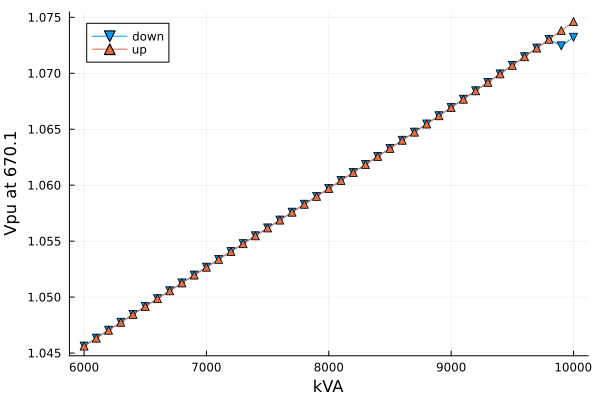

In [9]:
x_down = collect(range(start=kVA, step=-100, stop=min_kVA))
x_up = collect(range(start=min_kVA, step=100, stop=kVA))

plot(x_down, vs_down; markershape=:dtriangle, label="down")
plot!(x_up, vs_up; markershape=:utriangle, label="up")
xlabel!("kVA")
ylabel!("Vpu at $(bus_to_plot * "." * string(phase_to_plot))")

## PF = 0.9

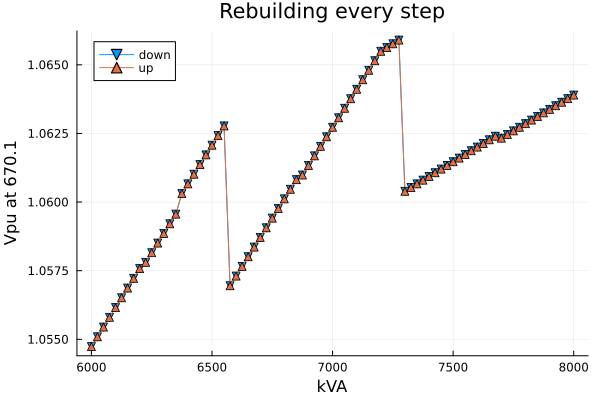

In [10]:
PF = 0.9

step = 25
rebuild()

bus_to_plot = "670"
phase_to_plot = 1

OpenDSS.PVsystems.First()
OpenDSS.PVsystems.pf(PF)

min_kVA = 6000
kVA=8000

vs_down = []

for pmpp in range(start=kVA, step=-step, stop=min_kVA)

    rebuild()
    
    OpenDSS.PVsystems.Pmpp(float(pmpp))
    OpenDSS.PVsystems.pf(PF)
    OpenDSS.Solution.Solve()
    @assert OpenDSS.Solution.Converged()
    push!(vs_down, dss_voltages_pu()[bus_to_plot][phase_to_plot])
end


vs_up = []

for pmpp in range(start=min_kVA, step=step, stop=kVA)

    rebuild()

    OpenDSS.PVsystems.Pmpp(float(pmpp))
    OpenDSS.PVsystems.pf(PF)
    OpenDSS.Solution.Solve()
    @assert OpenDSS.Solution.Converged()
    push!(vs_up, dss_voltages_pu()[bus_to_plot][phase_to_plot])
end

x_down = collect(range(start=kVA, step=-step, stop=min_kVA))
x_up = collect(range(start=min_kVA, step=step, stop=kVA))

plot(x_down, vs_down; markershape=:dtriangle, label="down")
plot!(x_up, vs_up; markershape=:utriangle, label="up")
xlabel!("kVA")
ylabel!("Vpu at $(bus_to_plot * "." * string(phase_to_plot))")
title!("Rebuilding every step")

Looks like three manifolds!

run again without rebuilding (reuse previous solution's voltage as the initial voltage)

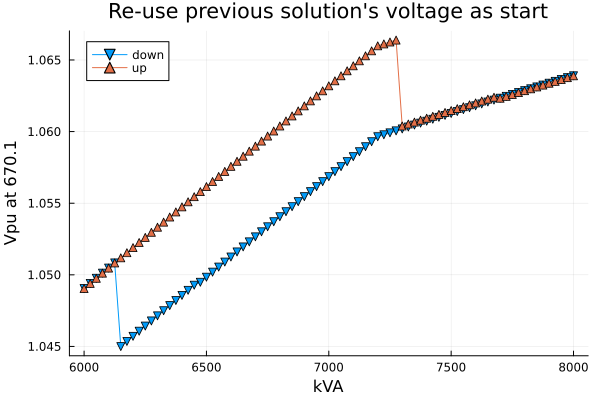

In [11]:
PF = 0.9

step = 25
rebuild()

bus_to_plot = "670"
phase_to_plot = 1

OpenDSS.PVsystems.First()
OpenDSS.PVsystems.pf(PF)

min_kVA = 6000
kVA=8000

vs_down = []

for pmpp in range(start=kVA, step=-step, stop=min_kVA)

    # rebuild()
    
    OpenDSS.PVsystems.Pmpp(float(pmpp))
    OpenDSS.PVsystems.pf(PF)
    OpenDSS.Solution.Solve()
    @assert OpenDSS.Solution.Converged()
    push!(vs_down, dss_voltages_pu()[bus_to_plot][phase_to_plot])
end


vs_up = []

for pmpp in range(start=min_kVA, step=step, stop=kVA)

    # rebuild()

    OpenDSS.PVsystems.Pmpp(float(pmpp))
    OpenDSS.PVsystems.pf(PF)
    OpenDSS.Solution.Solve()
    @assert OpenDSS.Solution.Converged()
    push!(vs_up, dss_voltages_pu()[bus_to_plot][phase_to_plot])
end

x_down = collect(range(start=kVA, step=-step, stop=min_kVA))
x_up = collect(range(start=min_kVA, step=step, stop=kVA))

plot(x_down, vs_down; markershape=:dtriangle, label="down")
plot!(x_up, vs_up; markershape=:utriangle, label="up")
xlabel!("kVA")
ylabel!("Vpu at $(bus_to_plot * "." * string(phase_to_plot))")
title!("Re-use previous solution's voltage as start")